In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/cell_images/cell_images"))

# Any results you write to the current directory are saved as output.

['Uninfected', 'Parasitized']


In [2]:
input_dir = "../input/cell_images/cell_images"
uninfected_dir = "../input/cell_images/cell_images/Uninfected"
infected_dir = "../input/cell_images/cell_images/Parasitized"

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [3]:
img_array = []
count = 0
for img in os.listdir(uninfected_dir):
    img_array.append(cv2.imread(os.path.join(uninfected_dir,img)))
    count+=1
    if(count == 5):
        break
        
count = 0

for img in os.listdir(infected_dir):
    img_array.append(cv2.imread(os.path.join(infected_dir,img)))
    count+=1
    if(count == 5):
        break

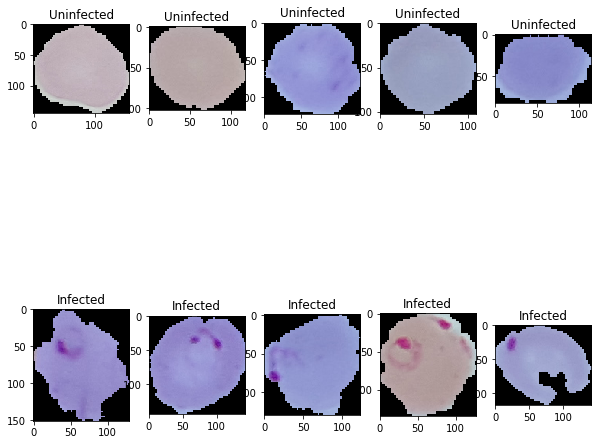

In [4]:
plt.figure(figsize=[10,10])
i = 0
for img_name in img_array:
    plt.subplot(2, 5,i+1)
    plt.imshow(img_name)
    if(i<5):
        plt.title("Uninfected")
    else:
        plt.title("Infected")
    i+=1
    

In [5]:
!pip install --upgrade pip
!pip install efficientnet
from keras import applications
from efficientnet.keras import EfficientNetB3
from keras import callbacks
from keras.models import Sequential

    100% |████████████████████████████████| 1.5MB 9.3MB/s 
  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3


In [6]:
img_array[0].shape

(145, 157, 3)

In [7]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  validation_split = 0.15,
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.,
                                validation_split = 0.15)

train_generator = train_datagen.flow_from_directory(
    directory = input_dir,
    class_mode = "binary",
    batch_size = 64,
    target_size = (32,32),
    subset = "training"
    )

val_generator = val_datagen.flow_from_directory(
    directory = input_dir,
    class_mode = "binary",
    batch_size = 64,
    target_size = (32,32),
    subset = "validation"
    )

Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.


In [8]:
efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)
model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               184440    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 10,982,609
Trainable params: 10,895

In [9]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history = model.fit_generator(
    train_generator,
    epochs = 75,
    steps_per_epoch = 15,
    validation_data = val_generator,
    validation_steps = 7
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/75
15/15 [==============================] - 36s 2s/step - loss: 0.7034 - acc: 0.5417 - val_loss: 0.7110 - val_acc: 0.5424
Epoch 2/75
15/15 [==============================] - 6s 395ms/step - loss: 0.6566 - acc: 0.5979 - val_loss: 0.6684 - val_acc: 0.5402
Epoch 3/75
15/15 [==============================] - 8s 518ms/step - loss: 0.6474 - acc: 0.6260 - val_loss: 0.6353 - val_acc: 0.6540
Epoch 4/75
15/15 [==============================] - 8s 546ms/step - loss: 0.6267 - acc: 0.6427 - val_loss: 0.6156 - val_acc: 0.6652
Epoch 5/75
15/15 [==============================] - 9s 579ms/step - loss: 0.5867 - acc: 0.6906 - val_loss: 0.5796 - val_acc: 0.7009
Epoch 6/75
15/15 [==============================] - 8s 553ms/step - loss: 0.5773 - acc: 0.7063 - val_loss: 0.5406 - val_acc: 0.7589
Epoch 7/75
15/15 [==============================] - 8s 526ms/step - loss: 0.5514 - a

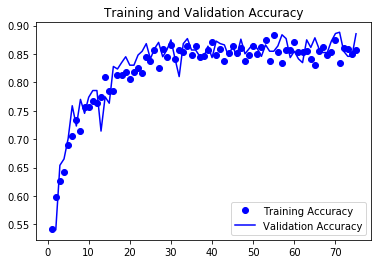

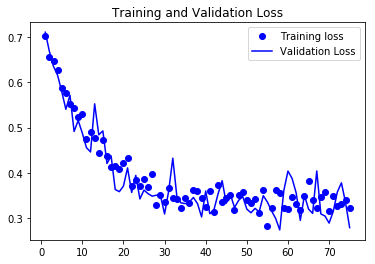

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()